# Комп’ютерний практикум No 1. Навчання регресiйної моделi методами градiєнтного спуску в TensorFlow2

## Хiд виконання роботи

Написати програму на Python, використовуючи TensorFlow2, яка задає i на-
вчає регресiйну модель методами градiєнтного спуску.

1. Завантажити початковi данi.
2. Представити данi графiчно.
3. Iнiцiалiзувати параметри: швидкiсть навчання, кiлькiсть епох (=100) i додатково, якщо задано згiдно з варiантом, кiлькiсть пакетiв i/або параметр регуляризацiї.

4. Iнiцiалiзувати вектор параметрiв.
5. Реалiзувати власний клас, наприклад, похiдний вiд tf.keras.Model.
6. Реалiзувати функцiю, яка задає модель, наприклад:
    - лiнiйну регресiю,
    - полiномiальну регресiю,
    - iншу криву, яку пiдiбрати вiдповiдно до заданих даних.
7. Задати функцiю втрат (одну згiдно з варiантом):
    - MSE,
    - MSE з регуляризацiєю за нормами L1 або L2.
8. Задати операцiю, яка буде викликатися на кожнiй iтерацiї алгоритма навчання:
    - алгоритм градiєнтного спуску,
    - алгоритм мiнi-пакетного градiєнтного спуску,
    - алгоритм градiєнтного спуску з моментом,
    - алгоритм Adagrad,
    - алгоритм Adadelta,
    - алгоритм Adam.
9. Виконати навчання моделi.
10. Розрахувати градiєнти використовуючи автоматичне диференцiювання i tf.GradientTape.

11. Виводити значення функцiї втрат через кожнi 10 епох - побудувати криву навчання.

12. В кiнцi навчання зберегти результуючу модель. Зберегти тiльки архiтектуру моделi в форматi JSON. Зберегти тiльки ваги моделi. Завантажити попередньо збережену модель.

13. Налаштувати гiперпараметр швидкiсть навчання i додатково, якщо задано згiдно варiанту, розмiр мiнi-пакета.

14. Дослiдити рiзнi значення параметра регуляризацiї i пiдiбрати найкраще з них, якщо згiдно з варiантом задано регуляризовану функцiю втрат. В цьому випадку данi мають бути попередньо розбитi на навчальний та перевiрочний набори.
15. Побудувати графiк з початковими даними та лiнiєю регресiї.

## Варіант 9 
Полiномiальна регресiя, алгоритм градiєнтного спуску з моментом, MSE
з регуляризацiєю за нормою L2.

(а)
```
X_data = np.linspace (−1, 1 , 101)
num_coef = 10
coef = [−100, 2, 3, −3000, 5, 6, 4, 300, 2, 600]
y_data = 0
for i in range(num_coef) :
    y_data += coef[i] * np.power(X_data, i )
y_data += np.random.randn(*X_data.shape) * 6.5
```
(б)
```
sklearn.datasets.make_friedman2
```

In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [70]:
from sklearn.datasets import make_friedman2

X_data, y_data = make_friedman2()

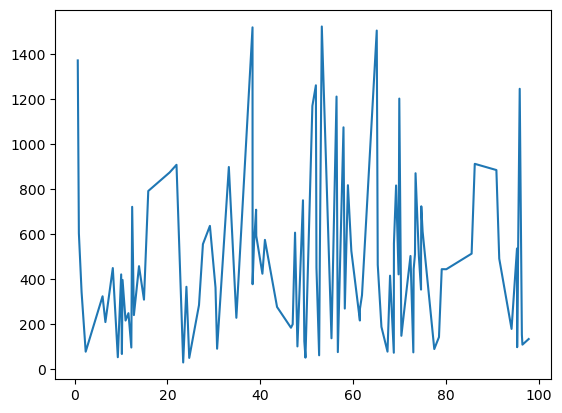

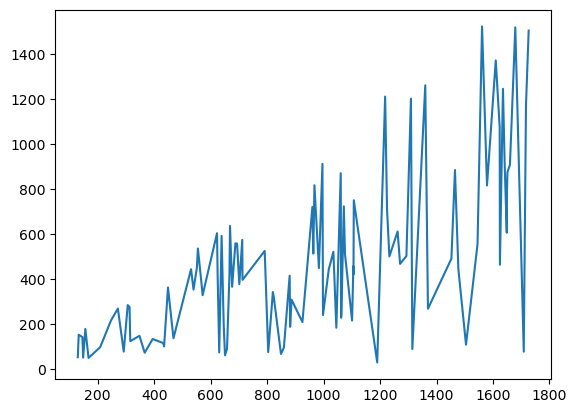

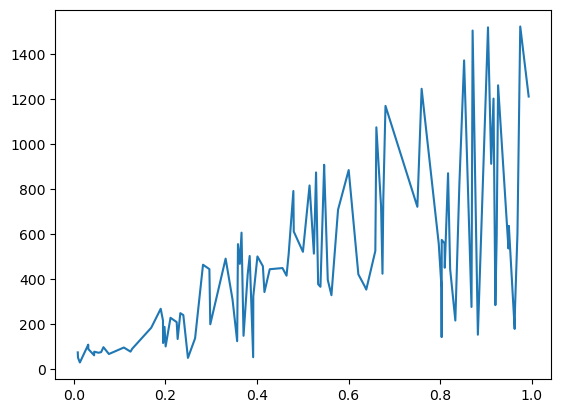

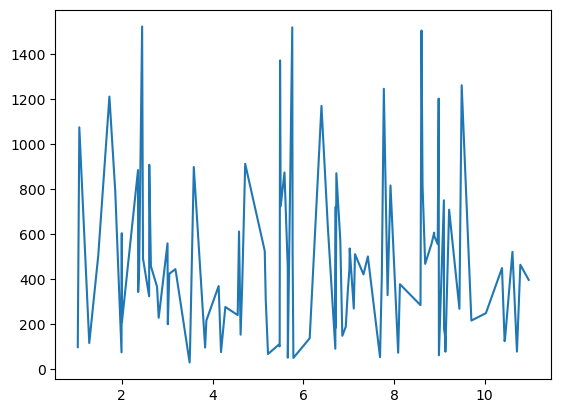

In [71]:
for x in X_data.T:
    idx = np.argsort(x)
    plt.plot(x[idx], y_data[idx], label="true")
    plt.show()

In [72]:
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

## Model & Loss

In [73]:
# Define custom model class
class PolyRegression(tf.keras.Model):
    def __init__(self, input_dim=4, num_coef=2):
        super().__init__()
        self.theta = tf.Variable(tf.random.normal([input_dim * num_coef, 1]), dtype=tf.float32, name="weight")
        self.bias = tf.Variable(0.0, dtype=tf.float32, name="bias")

    def call(self, x):
        # Create polynomial features
        poly_features = tf.concat([tf.pow(x, i) for i in range(num_coef)], axis=1)
        # Compute predictions
        y_pred = tf.linalg.matmul(poly_features, self.theta)
        return y_pred + self.bias
    
    
# Define loss function
def mse_loss_term(y_true, y_pred):
    error = tf.square(y_true - tf.squeeze((y_pred)))
    assert error.shape == y_true.shape
    mse_loss = tf.reduce_mean(error)
    return mse_loss


def l2_reg_loss_term(theta, l2_reg_param):
    l2_loss = tf.reduce_sum(tf.square(theta)) * l2_reg_param
    return l2_loss

In [74]:
def training_loop(
    model,
    optimizer,
    X_data,
    y_data,
    batch_size,
    epochs,
    l2_reg_param
):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        losses = []
        for i in range(0, len(X_data), batch_size):
            X_batch = X_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            with tf.GradientTape() as tape:
                y_pred = model(X_batch)
                loss = mse_loss_term(y_batch, y_pred) + l2_reg_loss_term(model.theta, l2_reg_param)
                losses.append(loss)

            gradients = tape.gradient(loss, [model.theta, model.bias])
            optimizer.apply_gradients(zip(gradients, [model.theta, model.bias]))

        loss = tf.reduce_mean(losses)
        history["train_loss"].append(loss.numpy())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
            
    return model, history

## Train

In [75]:
# Initialize parameters
epochs = 100
batch_size = 10
learning_rate = 0.01
momentum = 0.9
l2_reg_param = 0.01
num_coef = 2

# Define optimization algorithm
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

model = PolyRegression(X_data.shape[1], num_coef)


model, history = training_loop(
    model,
    optimizer,
    X_data,
    y_data,
    batch_size,
    epochs,
    l2_reg_param
)

Epoch 0, Loss: 162001.0625
Epoch 10, Loss: 22731.9297
Epoch 20, Loss: 22773.6152
Epoch 30, Loss: 22749.9863
Epoch 40, Loss: 22728.1875
Epoch 50, Loss: 22708.0742
Epoch 60, Loss: 22689.5059
Epoch 70, Loss: 22672.3711
Epoch 80, Loss: 22656.5586
Epoch 90, Loss: 22641.9629


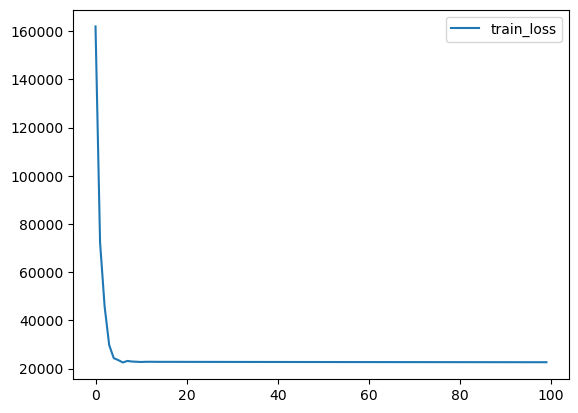

In [76]:
plt.plot(history["train_loss"], label="train_loss")
plt.legend()
# plt.yscale("log")

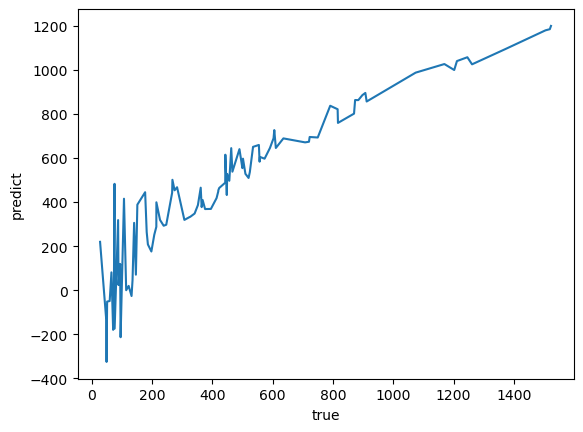

In [77]:
import matplotlib.pyplot as plt

idx = np.argsort(y_data)
plt.plot(y_data[idx], model(X_data).numpy()[idx]);
plt.ylabel("predict",)
plt.xlabel("true",);

## Save & Load

In [78]:
# Save model architecture as JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights('model_weights.h5')

# Load model architecture from JSON
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    
with tf.keras.utils.custom_object_scope({'PolyRegression': PolyRegression}):
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load model weights
loaded_model(X_data[:1])  # workaround for assigning variables to model
loaded_model.load_weights('model_weights.h5')

## Tune learning rate

In [79]:
# Initialize parameters
epochs = 100
batch_size = 10
momentum = 0.9
l2_reg_param = 0.01
num_coef = 2

results = {}
for learning_rate in [ 0.05, 0.01, 0.001, 3e-4]:
    # Define optimization algorithm
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model = PolyRegression(X_data.shape[1], num_coef)

    model, history = training_loop(
        model,
        optimizer,
        X_data,
        y_data,
        batch_size,
        epochs,
        l2_reg_param
    )
    results[learning_rate] = history["train_loss"][-1]
    
results

Epoch 0, Loss: 102957.8281
Epoch 10, Loss: 32149.8633
Epoch 20, Loss: 30074.4844
Epoch 30, Loss: 29822.8438
Epoch 40, Loss: 29795.5312
Epoch 50, Loss: 29783.4102
Epoch 60, Loss: 29772.5742
Epoch 70, Loss: 29763.9316
Epoch 80, Loss: 29757.6660
Epoch 90, Loss: 29753.3320
Epoch 0, Loss: 161709.7188
Epoch 10, Loss: 22732.3906
Epoch 20, Loss: 22773.9023
Epoch 30, Loss: 22750.2578
Epoch 40, Loss: 22728.4434
Epoch 50, Loss: 22708.3125
Epoch 60, Loss: 22689.7266
Epoch 70, Loss: 22672.5742
Epoch 80, Loss: 22656.7461
Epoch 90, Loss: 22642.1367
Epoch 0, Loss: 299054.2500
Epoch 10, Loss: 22727.6016
Epoch 20, Loss: 21944.0293
Epoch 30, Loss: 21950.4023
Epoch 40, Loss: 21948.5371
Epoch 50, Loss: 21945.8242
Epoch 60, Loss: 21943.0742
Epoch 70, Loss: 21940.3359
Epoch 80, Loss: 21937.6211
Epoch 90, Loss: 21934.9316
Epoch 0, Loss: 341734.1875
Epoch 10, Loss: 55980.3125
Epoch 20, Loss: 31334.9805
Epoch 30, Loss: 24490.1367
Epoch 40, Loss: 22599.5117
Epoch 50, Loss: 22081.5215
Epoch 60, Loss: 21941.6816
E

{0.05: 29750.719, 0.01: 22629.955, 0.001: 21932.53, 0.0003: 21892.172}

`learning_rate = 3e-4` є оптимальним значенням 

## Tune l2 regularization

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = X_data[:80], X_data[80:], y_data[:80], y_data[80:]

In [81]:
# Initialize parameters
epochs = 100
batch_size = 10
learning_rate = 3e-4
momentum = 0.9
num_coef = 2

results = {}
for l2_reg_param in [1, 0.1, 0.01, 0.001, 0]:
    # Define optimization algorithm
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model = PolyRegression(X_data.shape[1], num_coef)

    model, history = training_loop(
        model,
        optimizer,
        X_train,
        y_train,
        batch_size,
        epochs,
        l2_reg_param
    )
    
    results[l2_reg_param] = mse_loss_term(y_test, model(X_test)).numpy()
    
results

Epoch 0, Loss: 335588.3750
Epoch 10, Loss: 107731.9844
Epoch 20, Loss: 96913.3438
Epoch 30, Loss: 92559.9141
Epoch 40, Loss: 89375.9375
Epoch 50, Loss: 86727.2734
Epoch 60, Loss: 84487.3516
Epoch 70, Loss: 82590.0625
Epoch 80, Loss: 80982.9766
Epoch 90, Loss: 79621.8125
Epoch 0, Loss: 339596.7188
Epoch 10, Loss: 66861.3672
Epoch 20, Loss: 43120.9375
Epoch 30, Loss: 35618.4961
Epoch 40, Loss: 33221.4062
Epoch 50, Loss: 32428.5527
Epoch 60, Loss: 32139.6758
Epoch 70, Loss: 32009.1660
Epoch 80, Loss: 31928.6113
Epoch 90, Loss: 31864.1484
Epoch 0, Loss: 336213.8438
Epoch 10, Loss: 61531.2656
Epoch 20, Loss: 34846.0547
Epoch 30, Loss: 25589.8398
Epoch 40, Loss: 22376.8125
Epoch 50, Loss: 21262.3555
Epoch 60, Loss: 20876.4512
Epoch 70, Loss: 20743.1719
Epoch 80, Loss: 20697.2715
Epoch 90, Loss: 20681.4336
Epoch 0, Loss: 333998.0000
Epoch 10, Loss: 61167.0859
Epoch 20, Loss: 34038.6523
Epoch 30, Loss: 24537.4922
Epoch 40, Loss: 21207.5820
Epoch 50, Loss: 20041.7129
Epoch 60, Loss: 19634.4609


{1: 76886.05, 0.1: 32925.484, 0.01: 28284.66, 0.001: 27861.52, 0: 27811.95}

Відсутність регуляризації показує кращі результати в цьому випадку

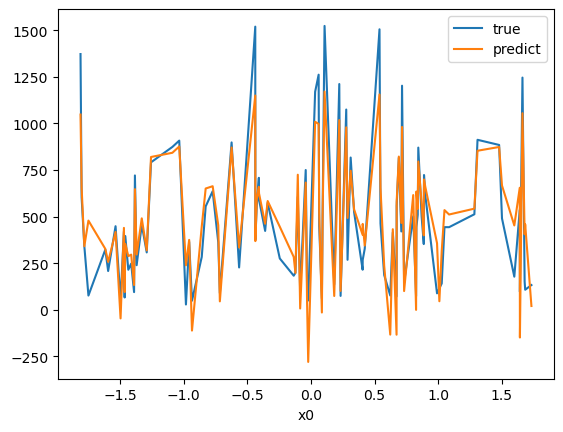

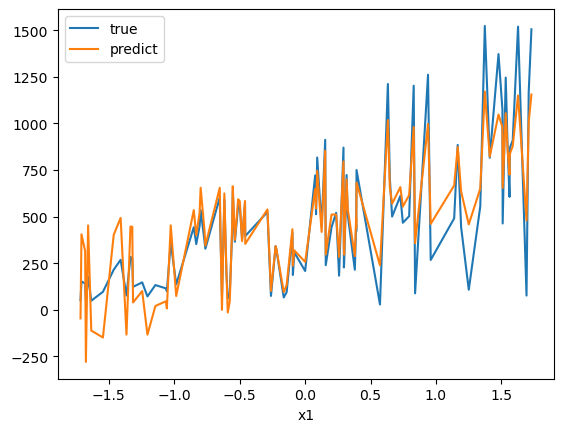

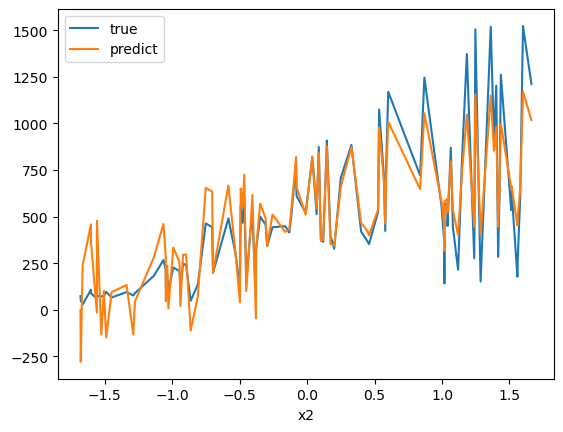

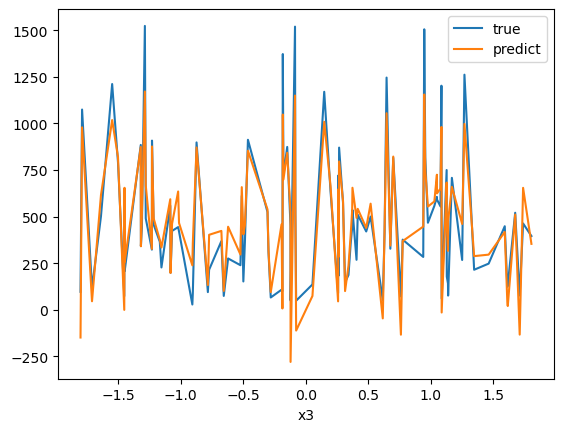

In [82]:
import matplotlib.pyplot as plt

y_pred = model(X_data).numpy()

for i, x in enumerate(X_data.T):
    idx = np.argsort(x)
    plt.plot(x[idx], y_data[idx], label="true")
    plt.plot(x[idx], y_pred[idx], label="predict");
    plt.xlabel(f"x{i}")
    plt.legend();
    plt.show()

